Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## AS OF THE END DATE OF THE COURSE:  
A lot of time has been spent on cleaning, scrubbing, and understanding the organization of the data.   I had to generate some calculated features, and further projects include parsing the text fields.   


 ### This spreadsheet will be modified to do the file cleaning, with analysis and visualisation in separate notebook. 
 I will take the 4 Lending Club CSV files to see if they can be 'stitched' together for processing.  

In [1]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

#import dataset
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 

# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_2015_Q1.csv"
#  
#                              iii) LendingClub_2014_Approved.csv

url = "/Users/Glenn/Documents/LendingClub/LendingClub_12-13.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_Approved_29MAY.csv"
lcd_raw = pd.read_csv(url,skiprows=1,
            parse_dates=['last_pymnt_d','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d'])

/Applications/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [2]:
lcd_raw.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
188120,1059224,1290827,35000,35000,35000,36 months,15.96%,1229.81,C,C5,...,0.00,2014-12-20,1244.72,NaT,2014-12-20,739,735,0,NaN,1
188121,1058722,1290521,12000,12000,12000,36 months,16.29%,423.61,D,D1,...,3.99,2012-04-20,423.61,NaT,2012-09-20,569,565,0,NaN,1
188122,1058291,1289878,12000,7775,7775,60 months,15.27%,186.08,C,C4,...,0.00,2015-05-20,186.08,2015-06-20,2015-05-20,744,740,0,NaN,1
188123,Total amount funded in policy code 1: 2700420250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
188124,Total amount funded in policy code 2: 82622275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [3]:
# Clean bottom of file and create new dataframe from it
lcd = lcd_raw[:-2].copy()

# Create Datetime fields from date information....
lcd = lcd.drop(lcd.index[lcd.last_pymnt_d == 'nan'])
lcd['last_pymnt_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.last_pymnt_d]
lcd['next_pymnt_date'] = [pd.to_datetime(j,format='%b-%Y', unit = "D") for j in lcd.next_pymnt_d]
lcd['last_credit_pull_date'] = [pd.to_datetime(j, unit = "D",format='%b-%Y') for j in lcd.last_credit_pull_d]
lcd['issue_date'] = [pd.to_datetime(j, format='%b-%Y', unit = "D") for j in lcd.issue_d]


In [4]:
lcd.tail()
# lcd.isnull().sum()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,last_pymnt_date,next_pymnt_date,last_credit_pull_date,issue_date
188118,1062400,1294262,20500,20500,20500,36 months,16.77%,728.54,D,D2,...,2015-03-20,579,575,0,NaN,1,2014-11-20,NaT,2015-03-20,2012-01-20
188119,1059394,1291010,15000,15000,15000,36 months,15.27%,521.97,C,C4,...,2014-12-20,684,680,0,NaN,1,2015-01-20,NaT,2014-12-20,2012-01-20
188120,1059224,1290827,35000,35000,35000,36 months,15.96%,1229.81,C,C5,...,2014-12-20,739,735,0,NaN,1,2014-12-20,NaT,2014-12-20,2012-01-20
188121,1058722,1290521,12000,12000,12000,36 months,16.29%,423.61,D,D1,...,2012-09-20,569,565,0,NaN,1,2012-04-20,NaT,2012-09-20,2012-01-20
188122,1058291,1289878,12000,7775,7775,60 months,15.27%,186.08,C,C4,...,2015-05-20,744,740,0,NaN,1,2015-05-20,2015-06-20,2015-05-20,2012-01-20


In [5]:
lcd.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       11723
emp_length                          0
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           106661
purpose                             0
title                               7
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_

In [24]:
# Substitute "No Response" for any #NA in title feature
lcd.title.fillna(value = "No response",inplace = True)
lcd.desc.fillna(value="No response", inplace = True)
lcd.emp_title.fillna(value="No response", inplace = True)

In [21]:
# replace all Nan's for 'mnths_since_last_delinq',  with 999....this is a kludge for now.  If this feature is used in logistic
# Regression, we'll want to make sure its far away from the other real delinquencies...
lcd['mths_since_last_delinq'].fillna(value=999, inplace=True)
lcd['mths_since_last_record'].fillna(value=999,inplace=True)
# lcd['mths_since_last_delinq'].unique()

In [42]:
# Drop certain features we don't need for now, and create a new dataframe 
#lcd.drop(['id','member_id','url', 'desc','title','emp_title','addr_state','zip_code',
#                   'funded_amnt_inv','revol_bal','revol_util','out_prncp','out_prncp_inv','total_pymnt',
#                   'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','collection_recovery_fee',
#                   'last_fico_range_high','last_fico_range_low','initial_list_status','policy_code',
#                   'earliest_cr_line'], axis=1,inplace=True)


In [22]:
#  Convert Field Employment Length into a classifier
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

# Now graph
# lcd['emp_length_numeric'].hist()
# plt.title('Employment Length counts')
# plt.xlabel('Employment Length (yrs)')

Employment length reasonably evenly distributed out to 5 years.    How is this distributed versus FICO score?

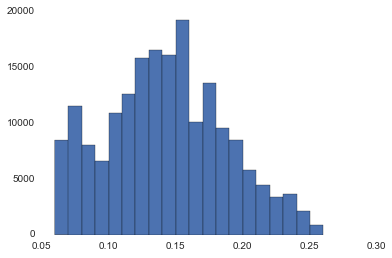

In [25]:
# Strip chars, convert int_rate series to float
lcd.int_rate.fillna(method='backfill',inplace = True)
lcd['clean_rates'] = [float(t.strip(' %'))/100 for t in lcd.int_rate]

# Now graph!
lcd['clean_rates'].hist(bins=20)

In [26]:
# clean term by splitting on spaces and converting numbers into float
lcd.term.fillna(method='backfill',inplace = True)
lcd['clean_term'] = [float (s.split(' ')[1]) for s in lcd.term]

In [30]:
# Create Sub Grade map 
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

In [28]:
# Create Categorical Variable from LC grades
lcd['grade_int']=lcd['grade'].map({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6})

In [37]:
# Use One Hot Encoder to turn Grade, Grade_Int into categorical variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded_grade_status = ohe.fit_transform(lcd[['grade_int']])

# Convert to dataframe and add to lcd
grade_status_columns = ('A','B','C','D','E','F','G')
grade_status_encoded_dataframe = pd.DataFrame(encoded_grade_status, columns=grade_status_columns)
# Add to lcd dataframe at end so we avoid problems with re-running cells

encoded_sub_grade_status = ohe.fit_transform(lcd[['sub_grade_int']])
sub_grade_status_columns = ('A1','A2','A3','A4','A5',
                            'B1','B2','B3','B4','B5',
                            'C1','C2','C3','C4','C5',
                            'D1','D2','D3','D4','D5',
                            'E1','E2','E3','E4','E5',
                            'F1','F2','F3','F4','F5',
                            'G1','G2','G3','G4','G5')
sub_grade_status_encoded_dataframe = pd.DataFrame(encoded_sub_grade_status, columns=sub_grade_status_columns)


In [38]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']

# backfill all NAs...in theory this might create some problems, but there aren't enough NAs to bias results. 
lcd['verification_status'].fillna(method='backfill',inplace = True)
lcd['verification_status_b'] = (lcd['verification_status']== 'VERIFIED - income') | (lcd['verification_status'] =='VERIFIED - income source')

KeyError: 'verification_status'

In [33]:
# lcd.drop(['verification_status','sub_grade','grade'],axis=1,inplace=True)

In [34]:
lcd.home_ownership.unique()

array(['RENT', 'MORTGAGE', 'OWN', 'NONE', 'OTHER'], dtype=object)

In [40]:
# Convert Home ownership into categorical variable and encode using One Hot Encoder

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2,'NONE':3,'OTHER':3})

lcd['home_ownership_int'].fillna(method = 'backfill', inplace= True)
ohe = OneHotEncoder(sparse=False)

# Use OHE to convert to feature columns 
encoded_ownership_status = ohe.fit_transform(lcd[['home_ownership_int']])

# Now convert to dataframe and add to lcd
# Ownship Status columns reduced to 3.  "Other" not present in 2015 file
ownership_status_columns = ('Rent','Own','Mortgage','None - Other')
ownership_encoded_dataframe = pd.DataFrame(encoded_ownership_status, columns=ownership_status_columns)

lcd = pd.concat([ownership_encoded_dataframe, lcd],axis=1)

In [41]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)

In [42]:
# Define 'fico_interp' as midpoint between fico_range_low and fico_range_high

lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

In [43]:
lcd['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'Charged Off',
       'Default', 'In Grace Period', 'Late (16-30 days)'], dtype=object)

In [44]:
'''
Defaults will become our Response variable (y)
FOR LENDING CLUB 07-12.CSV" file, there are additional fields "Does not meet the credit policy.
See notes from Lending Club call Jun17 15 for further info
LOAN STATUS CATEGORIES 
'Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
'In Grace Period' 'Late (16-30 days)'
'Does not meet the credit policy.  Status:Current'
'Does not meet the credit policy.  Status:Charged Off'
'Does not meet the credit policy.  Status:Fully Paid'
'Does not meet the credit policy.  Status:Late (16-30 days)'
'Does not meet the credit policy.  Status:In Grace Period'
'Does not meet the credit policy.  Status:Late (31-120 days)']

THIS IS FOR THE 07-12 LOAN FILE ONLY
lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120 days)':4,'In Grace Period':5,'Late (16-30 days)':6,
                            'Does not meet the credit policy.  Status:Current':7,
                            'Does not meet the credit policy.  Status:Charged Off':8,
                            'Does not meet the credit policy.  Status:Fully Paid':9,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':10,
                            'Does not meet the credit policy.  Status:In Grace Period':11,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':12,
                            'Does not meet the credit policy.  Status:Default' :13}) 
'''
lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120 days)':4,'In Grace Period':5,'Late (16-30 days)':6})


In [45]:
# Convert loan status by using One Hot Encoder (OHE)

# THere's only one na, so this shouldn't bias our results tremendously...
lcd['loan_status_int'].fillna(method = 'backfill', inplace= True)

# Use OHE to create multiple features out of loan_status_int
encoded_loan_status = ohe.fit_transform(lcd[['loan_status_int']])

# Create a dataframe to add to lcd
# This mapping is for 07-12 file which had exceptions to the credit policy

'''
loan_status_columns = ('Fully Paid','Charged Off', 'Current','Default','Late (31-120)',
                      'Late (Grace Period}', 'Late (16-30)', 'Outside Credit Policy: Current',
                      'Outside Credit Policy: Charged Off', 'Outside Credit Policy: Fully Paid'
                      'Outside Credit Policy: Late (16-30)', 'Outside Credit Policy: Grace Period',
                      'Outside Credit Policy: Late (31-120)', 'Outside Credit Policy: (Default)')
'''
loan_status_columns = ('Fully Paid','Charged Off', 'Current','Default','Late (31-120)',
                      'Late (Grace Period}', 'Late (16-30)')
encoded_loan_status_dataframe = pd.DataFrame(encoded_loan_status, columns=loan_status_columns)

In [46]:
# Concat the categorical dataframes to lcd
lcd = pd.concat([lcd, grade_status_encoded_dataframe], axis=1)
lcd = pd.concat([lcd, sub_grade_status_encoded_dataframe], axis=1)
lcd = pd.concat([lcd, encoded_loan_status_dataframe], axis=1)
# encoded_dataframe.head()

In [51]:
lcd['cum_defaults']= lcd['Default']+lcd['Charged Off']
lcd['cum_defaults'].sum()

17478.0

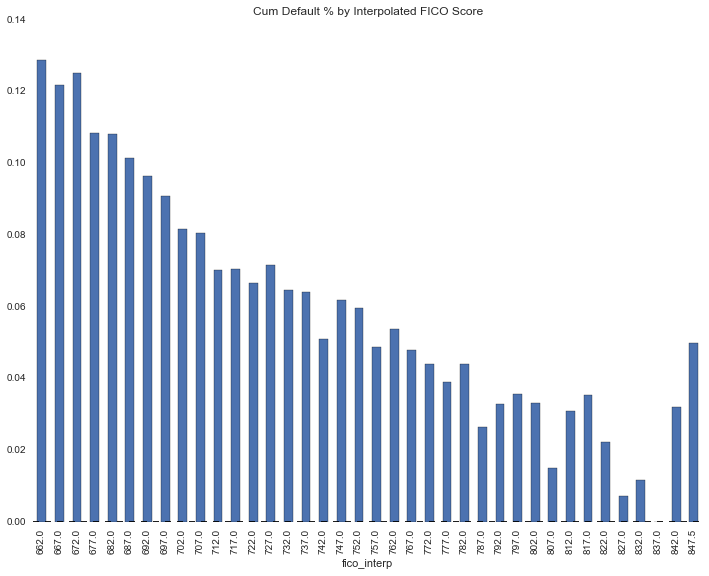

In [52]:
from itertools import groupby

# Graph default rates per bucket by FICO scores...

fico_graph = lcd.groupby(lcd.fico_interp)['cum_defaults'].sum()/lcd.groupby(lcd.fico_interp)['cum_defaults'].count()

fico_graph.plot(figsize=(12,9), kind = 'bar',title = 'Cum Default % by Interpolated FICO Score')

In [53]:
from itertools import groupby

# Graph default rates per bucket by Lending Club scores...

lendclub_graph = lcd.groupby(lcd.grade)['cum_defaults'].sum()/lcd.groupby(lcd.grade)['cum_defaults'].count()

lendclub_graph.plot(kind = 'bar',figsize=(12,9), title = 'Cum Default % by Lending Club Score')

AttributeError: 'DataFrame' object has no attribute 'grade'

In [18]:
# lcd.to_csv("/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv")

In [19]:
# lcd_temp = pd.read_csv("/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv", parse_dates=['last_pymnt_date','issue_date',
                                                                                                        'last_credit_pull_date','last_pymnt_date','next_pymnt_date'])

In [59]:
# print lcd_temp2['issue_date'].dtype
# print lcd_temp2['last_pymnt_date'].dtype
#
# print lcd_temp2.issue_date.isnull().sum()
# print lcd_temp2.issue_date.unique()
# print lcd_temp2.last_pymnt_date.unique()
# print lcd_temp2.last_pymnt_date.isnull().sum()

# Calculated feature measures distance between last payment date and issue date. 
# However, default is only a subset of this. 
# For now, we'll let default flag determine if this really is time to default

# Drop  nulls implictly
lcd_temp = lcd[pd.notnull(lcd.last_pymnt_date) & pd.notnull(lcd.issue_date)]

# Calculate datetime 
lcd_temp['time_to_default']= (lcd_temp.last_pymnt_date - lcd_temp.issue_date)

# Convert to days
lcd_temp['time_to_default'] = [j.days for j in lcd_temp.time_to_default]

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
